## Principles and Applications of Data Science (Spring 2020)
## Term Project

### Student ID Number: 105590009 105590023 105590024 105590026
### Name: 張文有 芮嘉輝 黃泀翰 黃彥穎

### load libraries

In [1]:
import time
import warnings
import random
import pandas as pd
import datetime
import lightgbm as lgb
import xgboost as xgb
import seaborn as sns
import numpy as np
import json
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import ExtraTreesRegressor
from sklearn import metrics
from mlxtend.regressor import StackingCVRegressor

In [2]:
# ignore warnings
warnings.filterwarnings('ignore')

### 讀取資料

In [3]:
# json parser
def jsonParser(data):
    result = json.loads(data)
    return result

In [4]:
data = pd.read_csv("./Data/ted_main.csv")
data.head()

,comments,description,duration,event,film_date,languages,main_speaker,name,num_speaker,published_date,ratings,related_talks,speaker_occupation,tags,title,url,views
0,4553,Sir Ken Robinson makes an entertaining and pro...,1164,TED2006,1140825600,60,Ken Robinson,Ken Robinson: Do schools kill creativity?,1,1151367060,"[{'id': 7, 'name': 'Funny', 'count': 19645}, {...","[{'id': 865, 'hero': 'https://pe.tedcdn.com/im...",Author/educator,"['children', 'creativity', 'culture', 'dance',...",Do schools kill creativity?,https://www.ted.com/talks/ken_robinson_says_sc...,47227110
1,265,With the same humor and humanity he exuded in ...,977,TED2006,1140825600,43,Al Gore,Al Gore: Averting the climate crisis,1,1151367060,"[{'id': 7, 'name': 'Funny', 'count': 544}, {'i...","[{'id': 243, 'hero': 'https://pe.tedcdn.com/im...",Climate advocate,"['alternative energy', 'cars', 'climate change...",Averting the climate crisis,https://www.ted.com/talks/al_gore_on_averting_...,3200520
2,124,New York Times columnist David Pogue takes aim...,1286,TED2006,1140739200,26,David Pogue,David Pogue: Simplicity sells,1,1151367060,"[{'id': 7, 'name': 'Funny', 'count': 964}, {'i...","[{'id': 1725, 'hero': 'https://pe.tedcdn.com/i...",Technology columnist,"['computers', 'entertainment', 'interface desi...",Simplicity sells,https://www.ted.com/talks/david_pogue_says_sim...,1636292
3,200,"In an emotionally charged talk, MacArthur-winn...",1116,TED2006,1140912000,35,Majora Carter,Majora Carter: Greening the ghetto,1,1151367060,"[{'id': 3, 'name': 'Courageous', 'count': 760}...","[{'id': 1041, 'hero': 'https://pe.tedcdn.com/i...",Activist for environmental justice,"['MacArthur grant', 'activism', 'business', 'c...",Greening the ghetto,https://www.ted.com/talks/majora_carter_s_tale...,1697550
4,593,You've never seen data presented like this. Wi...,1190,TED2006,1140566400,48,Hans Rosling,Hans Rosling: The best stats you've ever seen,1,1151440680,"[{'id': 9, 'name': 'Ingenious', 'count': 3202}...","[{'id': 2056, 'hero': 'https://pe.tedcdn.com/i...",Global health expert; data visionary,"['Africa', 'Asia', 'Google', 'demo', 'economic...",The best stats you've ever seen,https://www.ted.com/talks/hans_rosling_shows_t...,12005869


### Cleaning up the data

In [5]:
pd.isnull(data).sum()

comments              0
description           0
duration              0
event                 0
film_date             0
languages             0
main_speaker          0
name                  0
num_speaker           0
published_date        0
ratings               0
related_talks         0
speaker_occupation    6
tags                  0
title                 0
url                   0
views                 0
dtype: int64

In [6]:
# 共有6個遺失的演講者職業，使用other填補
for index, row in data.iterrows():
    if pd.isnull(row['speaker_occupation']):
        data['speaker_occupation'][index] = 'Other'

#### related_talks

In [7]:
data['related_talks'][0]

'[{\'id\': 865, \'hero\': \'https://pe.tedcdn.com/images/ted/172559_800x600.jpg\', \'speaker\': \'Ken Robinson\', \'title\': \'Bring on the learning revolution!\', \'duration\': 1008, \'slug\': \'sir_ken_robinson_bring_on_the_revolution\', \'viewed_count\': 7266103}, {\'id\': 1738, \'hero\': \'https://pe.tedcdn.com/images/ted/de98b161ad1434910ff4b56c89de71af04b8b873_1600x1200.jpg\', \'speaker\': \'Ken Robinson\', \'title\': "How to escape education\'s death valley", \'duration\': 1151, \'slug\': \'ken_robinson_how_to_escape_education_s_death_valley\', \'viewed_count\': 6657572}, {\'id\': 2276, \'hero\': \'https://pe.tedcdn.com/images/ted/3821f3728e0b755c7b9aea2e69cc093eca41abe1_2880x1620.jpg\', \'speaker\': \'Linda Cliatt-Wayman\', \'title\': \'How to fix a broken school? Lead fearlessly, love hard\', \'duration\': 1027, \'slug\': \'linda_cliatt_wayman_how_to_fix_a_broken_school_lead_fearlessly_love_hard\', \'viewed_count\': 1617101}, {\'id\': 892, \'hero\': \'https://pe.tedcdn.com/ima

In [8]:
data['related_views'] = 0

for index, row in data.iterrows():
    vids = row['related_talks'].split(',')
    counter = 0
    total = 0
    for views in vids:
        if 'viewed_count' in views:
            view = views.split(':')
            # get rid of brackets and spaces
            view[1] = view[1].replace("]", "")
            view[1] = view[1].replace(" ", "")
            view[1] = view[1].replace("}", "")
            total+=int(view[1])
            counter+=1
    data['related_views'][index] = total/counter

In [9]:
data['published_date'] = data['published_date'].apply(lambda x: datetime.date.fromtimestamp(int(x)))
data['day'] = data['published_date'].apply(lambda x: x.weekday())
data['month'] = data['published_date'].apply(lambda x: x.month)
data['year'] = data['published_date'].apply(lambda x: x.year)
data['film_date'] = data['film_date'].apply(lambda x: datetime.date.fromtimestamp(int(x)))
data['day_film'] = data['film_date'].apply(lambda x: x.weekday())
data['month_film'] = data['film_date'].apply(lambda x: x.month)
data['year_film'] = data['film_date'].apply(lambda x: x.year)

In [10]:
to_cat = {"day":   {0: "Monday", 1: "Tuesday", 2: "Wednesday", 3: "Thurday", 4: "Friday", 5: "Saturday",
                    6: "Sunday" },
          "month": {1: "January", 2: "February", 3: "March", 4: "April", 5: "May", 6: "June", 7: "July", 8: "August", 
                    9: "September", 10: "October", 11: "November", 12: "December"},
          "year":  {2006: "2006", 2007: "2007", 2008: "2008", 2009: "2009", 2010: "2010", 2011: "2011", 2012: "2012", 
                    2013: "2013", 2014: "2014", 2015: "2015", 2016: "2016", 2017: "2017"},
          "day_film":   {0: "Monday", 1: "Tuesday", 2: "Wednesday", 3: "Thurday", 4: "Friday", 5: "Saturday",
                    6: "Sunday" },
          "month_film": {1: "January", 2: "February", 3: "March", 4: "April", 5: "May", 6: "June", 7: "July", 8: "August", 
                    9: "September", 10: "October", 11: "November", 12: "December"},
          "year_film":  {2006: "2006", 2007: "2007", 2008: "2008", 2009: "2009", 2010: "2010", 2011: "2011", 2012: "2012", 
                    2013: "2013", 2014: "2014", 2015: "2015", 2016: "2016", 2017: "2017"}}

data.replace(to_cat, inplace=True)

In [11]:
print('Number of unique events: ',data['event'].unique().shape[0])
data['event'].unique()

Number of unique events:  355


array(['TED2006', 'TED2004', 'TED2005', 'TEDGlobal 2005', 'TEDSalon 2006',
       'TED2003', 'TED2007', 'TED2002', 'TEDGlobal 2007',
       'TEDSalon 2007 Hot Science', 'Skoll World Forum 2007', 'TED2008',
       'TED1984', 'TED1990', 'DLD 2007', 'EG 2007', 'TED1998',
       'LIFT 2007', 'TED Prize Wish', 'TEDSalon 2009 Compassion',
       'Chautauqua Institution', 'Serious Play 2008', 'Taste3 2008',
       'TED2001', 'TED in the Field', 'TED2009', 'EG 2008',
       'Elizabeth G. Anderson School', 'TEDxUSC', 'TED@State',
       'TEDGlobal 2009', 'TEDxKC', 'TEDIndia 2009',
       'TEDSalon London 2009', 'Justice with Michael Sandel',
       'Business Innovation Factory', 'TEDxTC',
       'Carnegie Mellon University', 'Stanford University',
       'AORN Congress', 'University of California', 'TEDMED 2009',
       'Royal Institution', 'Bowery Poetry Club', 'TEDxSMU',
       'Harvard University', 'TEDxBoston 2009', 'TEDxBerlin', 'TED2010',
       'TEDxAmsterdam', 'World Science Festival', 

In [12]:
# initialise all values as 'Other' to assign this category
# to all entries that don't fit into the chosen categories
data['event_category'] = 'Other'

for i in range(len(data)):
    if data['event'][i][0:5]=='TED20':
        data['event_category'][i] = 'TED2000s'
    elif data['event'][i][0:5]=='TED19':
        data['event_category'][i] = 'TED1900s'
    elif data['event'][i][0:4]=='TEDx':
        data['event_category'][i] = "TEDx"
    elif data['event'][i][0:7]=='TED@BCG':
        data['event_category'][i] = 'TED@BCG'
    elif data['event'][i][0:4]=='TED@':
        data['event_category'][i] = "TED@"
    elif data['event'][i][0:8]=='TEDSalon':
        data['event_category'][i] = "TEDSalon"
    elif data['event'][i][0:9]=='TEDGlobal':
        data['event_category'][i] = 'TEDGlobal'
    elif data['event'][i][0:8]=='TEDWomen':
        data['event_category'][i] = 'TEDWomen'
    elif data['event'][i][0:6]=='TEDMED':
        data['event_category'][i] = 'TEDMED'
    elif data['event'][i][0:3]=='TED':
        data['event_category'][i] = 'TEDOther'

In [13]:
data['event_category'].unique()

array(['TED2000s', 'TEDGlobal', 'TEDSalon', 'Other', 'TED1900s',
       'TEDOther', 'TEDx', 'TED@', 'TEDMED', 'TEDWomen', 'TED@BCG'],
      dtype=object)

### tags

In [14]:
import ast
destring = []
for number in range(len(data)):
    #Remove string
    destring.append(ast.literal_eval(data['tags'][number]))
data['Tags'] = pd.Series(destring)

In [15]:
from gensim.models import KeyedVectors
model = KeyedVectors.load_word2vec_format("./GoogleNews-vectors-negative300.bin", binary=True)

In [16]:
listed = [item for sublist in destring for item in sublist]
listed = pd.Series(listed)
lists = list(listed.unique())
lists2 = [ x for x in lists if " " not in x ]
lists2 = [ x for x in lists2 if "-" not in x ]

In [17]:
lists2.remove('archaeology')
lists2.remove('TEDYouth')
lists2.remove('deextinction')
lists2.remove('blockchain')
lists2.remove('TEDNYC')

Text(0.5, 1, 'Tag Clusters')

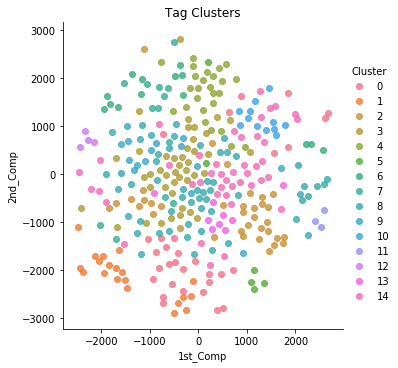

In [18]:
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

labels = []
tokens = []

for word in lists2:
    tokens.append(model[word])
    labels.append(word)

tsne_model = TSNE(perplexity=50, n_components=2, init='pca', n_iter=105000, random_state=17,learning_rate=5500)
new_values = tsne_model.fit_transform(tokens)

kmeans = KMeans(n_clusters=15,n_init=200)
kmeans.fit(tokens)
clusters = kmeans.predict(tokens)

df_tsne = pd.DataFrame(new_values, columns=['1st_Comp', '2nd_Comp'])
df_tsne['Cluster'] = clusters

sns.lmplot(x='1st_Comp', y='2nd_Comp', data=df_tsne, hue='Cluster', fit_reg=False)
plt.title("Tag Clusters")

In [19]:
convert = {labels[word]: clusters[word] for word in range(len(labels))}

In [20]:
comp = pd.DataFrame(labels)
comp['cluster'] = clusters

In [21]:
comp_conver = {0:'Organizing/Perceiving Information',1:'animals/organisms',2:'exploration',3:'Scientific Fields',
              4:'media/entertainment',5:'arts/creativity',6:'Epidemics',7:'Humanity/Progress',8:'Vices/Prejudices',
              9:'robots/prosthetics',10:'music',11:'philanthropy/religion',12:'Middle East',13:'Global issues',
              14:'Outer-Space',15:'NA'}

In [22]:
comp['group'] = 'None'
for ii in range(len(comp)):
    comp['group'][ii] = comp_conver[comp['cluster'][ii]]
    
unique = comp['group'].unique()

In [23]:
for group in unique:
    data[group+'_tag'] = 0
    for item in range(len(data['Tags'])):
        for ii in data['Tags'][item]:
            try:
                clust = convert[ii]
            except KeyError:
                clust = 15
            grouping = comp_conver[clust]
            if grouping == group:
                data[group+'_tag'][item] = 1

In [24]:
data.filter(like='_tag', axis=1).head()

,Vices/Prejudices_tag,Outer-Space_tag,exploration_tag,Scientific Fields_tag,Organizing/Perceiving Information_tag,media/entertainment_tag,robots/prosthetics_tag,Global issues_tag,Humanity/Progress_tag,music_tag,animals/organisms_tag,Epidemics_tag,Middle East_tag,arts/creativity_tag,philanthropy/religion_tag
0,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0
1,1,1,0,1,0,1,0,0,0,0,0,0,0,0,0
2,0,1,1,1,0,0,1,1,0,0,0,0,0,0,0
3,1,0,0,1,1,0,0,0,1,0,0,0,0,0,0
4,1,0,0,1,0,1,1,1,0,0,0,0,0,0,0


### Final touches on the dataset

In [25]:
views = data['views']
comments = data['comments']
data = data.drop(['comments', 'description', 'event', 'film_date', 'main_speaker', 'name', 'published_date', 'ratings', 
           'related_talks', 'tags', 'title', 'url','year_film','day_film', 'views', 'speaker_occupation', 'Tags'], 1)
data.head()

,duration,languages,num_speaker,related_views,day,month,year,month_film,event_category,Vices/Prejudices_tag,...,media/entertainment_tag,robots/prosthetics_tag,Global issues_tag,Humanity/Progress_tag,music_tag,animals/organisms_tag,Epidemics_tag,Middle East_tag,arts/creativity_tag,philanthropy/religion_tag
0,1164,60,1,3027062,Tuesday,June,2006,February,TED2000s,1,...,1,0,0,0,0,0,0,0,0,0
1,977,43,1,1118767,Tuesday,June,2006,February,TED2000s,1,...,1,0,0,0,0,0,0,0,0,0
2,1286,26,1,1846195,Tuesday,June,2006,February,TED2000s,0,...,0,1,1,0,0,0,0,0,0,0
3,1116,35,1,776189,Tuesday,June,2006,February,TED2000s,1,...,0,0,0,1,0,0,0,0,0,0
4,1190,48,1,1907337,Wednesday,June,2006,February,TED2000s,1,...,1,1,1,0,0,0,0,0,0,0


In [26]:
# data2 = data.filter(like='_tag', axis=1)
# data = data.drop(data2.columns, 1)
# data.head()

data_final = pd.get_dummies(data)
data_final.shape

(2550, 73)

In [27]:
def groupView(view, mean, std):
    if view >= mean + 3*std:
        return 1
    elif view >= mean + 2 *std:
        return 2
    elif view >= mean + std:
        return 3
    elif view >= mean:
        return 4
    elif view < mean:
        return 5
    return 0

In [28]:
data_final['target'] = views.apply(lambda x: groupView(x, views.mean(), views.std()))
data_final.head()

,duration,languages,num_speaker,related_views,Vices/Prejudices_tag,Outer-Space_tag,exploration_tag,Scientific Fields_tag,Organizing/Perceiving Information_tag,media/entertainment_tag,...,event_category_TED2000s,event_category_TED@,event_category_TED@BCG,event_category_TEDGlobal,event_category_TEDMED,event_category_TEDOther,event_category_TEDSalon,event_category_TEDWomen,event_category_TEDx,target
0,1164,60,1,3027062,1,1,1,1,1,1,...,1,0,0,0,0,0,0,0,0,1
1,977,43,1,1118767,1,1,0,1,0,1,...,1,0,0,0,0,0,0,0,0,4
2,1286,26,1,1846195,0,1,1,1,0,0,...,1,0,0,0,0,0,0,0,0,5
3,1116,35,1,776189,1,0,0,1,1,0,...,1,0,0,0,0,0,0,0,0,5
4,1190,48,1,1907337,1,0,0,1,0,1,...,1,0,0,0,0,0,0,0,0,1


In [111]:
from math import log
data_final['power_log_views'] = views.apply(lambda x: log(x))
data_final.head(15)

,duration,languages,num_speaker,related_views,Vices/Prejudices_tag,Outer-Space_tag,exploration_tag,Scientific Fields_tag,Organizing/Perceiving Information_tag,media/entertainment_tag,...,event_category_TED@,event_category_TED@BCG,event_category_TEDGlobal,event_category_TEDMED,event_category_TEDOther,event_category_TEDSalon,event_category_TEDWomen,event_category_TEDx,target,power_log_views
0,1164,60,1,3027062,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,1,17.670479
1,977,43,1,1118767,1,1,0,1,0,1,...,0,0,0,0,0,0,0,0,4,14.978824
2,1286,26,1,1846195,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,5,14.307943
3,1116,35,1,776189,1,0,0,1,1,0,...,0,0,0,0,0,0,0,0,5,14.344697
4,1190,48,1,1907337,1,0,0,1,0,1,...,0,0,0,0,0,0,0,0,1,16.300906
5,1305,36,1,8376548,1,1,1,1,0,1,...,0,0,0,0,0,0,0,0,1,16.844939
6,992,31,1,2756619,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,4,15.142582
7,1198,19,1,1160553,1,1,0,1,0,0,...,0,0,0,0,0,0,0,0,5,13.782720
8,1485,32,1,2468715,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,4,14.758622
9,1262,31,1,2027453,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,4,14.945619


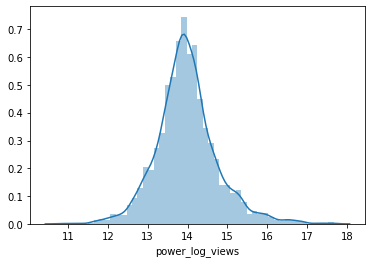

In [114]:
sns.distplot(data_final['power_log_views'])

In [116]:
data_final['target_log'] = data_final['power_log_views'].apply(lambda x: groupView(x, data_final['power_log_views'].mean(), data_final['power_log_views'].std()))
data_final.head()

,duration,languages,num_speaker,related_views,Vices/Prejudices_tag,Outer-Space_tag,exploration_tag,Scientific Fields_tag,Organizing/Perceiving Information_tag,media/entertainment_tag,...,event_category_TED@BCG,event_category_TEDGlobal,event_category_TEDMED,event_category_TEDOther,event_category_TEDSalon,event_category_TEDWomen,event_category_TEDx,target,power_log_views,target_log
0,1164,60,1,3027062,1,1,1,1,1,1,...,0,0,0,0,0,0,0,1,17.670479,1
1,977,43,1,1118767,1,1,0,1,0,1,...,0,0,0,0,0,0,0,4,14.978824,3
2,1286,26,1,1846195,0,1,1,1,0,0,...,0,0,0,0,0,0,0,5,14.307943,4
3,1116,35,1,776189,1,0,0,1,1,0,...,0,0,0,0,0,0,0,5,14.344697,4
4,1190,48,1,1907337,1,0,0,1,0,1,...,0,0,0,0,0,0,0,1,16.300906,1


## Mechine Learning

In [107]:
cols = data_final.columns
cols

Index(['duration', 'languages', 'num_speaker', 'related_views',
       'Vices/Prejudices_tag', 'Outer-Space_tag', 'exploration_tag',
       'Scientific Fields_tag', 'Organizing/Perceiving Information_tag',
       'media/entertainment_tag', 'robots/prosthetics_tag',
       'Global issues_tag', 'Humanity/Progress_tag', 'music_tag',
       'animals/organisms_tag', 'Epidemics_tag', 'Middle East_tag',
       'arts/creativity_tag', 'philanthropy/religion_tag', 'day_Friday',
       'day_Monday', 'day_Saturday', 'day_Sunday', 'day_Thurday',
       'day_Tuesday', 'day_Wednesday', 'month_April', 'month_August',
       'month_December', 'month_February', 'month_January', 'month_July',
       'month_June', 'month_March', 'month_May', 'month_November',
       'month_October', 'month_September', 'year_2006', 'year_2007',
       'year_2008', 'year_2009', 'year_2010', 'year_2011', 'year_2012',
       'year_2013', 'year_2014', 'year_2015', 'year_2016', 'year_2017',
       'month_film_April', 'month_fil

In [138]:
data_train_std = data_final[['languages','related_views','duration']]

In [140]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
sc.fit(data_train_std)
X_data_std = sc.transform(data_train_std)

array([[ 3.41719028,  0.60733281,  0.90253409],
       [ 1.63924075, -0.51283534,  0.40244824],
       [-0.13870877, -0.08583549,  1.22879331],
       ...,
       [-2.75334043, -0.05752803, -0.46935917],
       [-2.75334043,  0.74420054,  0.73138172],
       [-2.75334043, -0.06621738, -0.82236095]])

In [142]:
data_new = X_data_std.join(data_final[['Vices/Prejudices_tag', 'Outer-Space_tag', 'exploration_tag',
       'Scientific Fields_tag', 'Organizing/Perceiving Information_tag',
       'media/entertainment_tag', 'robots/prosthetics_tag',
       'Global issues_tag', 'Humanity/Progress_tag', 'music_tag',
       'animals/organisms_tag', 'Epidemics_tag', 'Middle East_tag',
       'arts/creativity_tag', 'philanthropy/religion_tag']])

AttributeError: 'numpy.ndarray' object has no attribute 'join'

In [143]:
data_new.columns

NameError: name 'data_new' is not defined

In [127]:
X_train, X_test, y_train, y_test = train_test_split(data_final[['languages','related_views','duration','Vices/Prejudices_tag', 'Outer-Space_tag', 'exploration_tag',
       'Scientific Fields_tag', 'Organizing/Perceiving Information_tag',
       'media/entertainment_tag', 'robots/prosthetics_tag',
       'Global issues_tag', 'Humanity/Progress_tag', 'music_tag',
       'animals/organisms_tag', 'Epidemics_tag', 'Middle East_tag',
       'arts/creativity_tag', 'philanthropy/religion_tag']], data_final[['target_log']], test_size=0.3, random_state=0)

In [136]:
X_train.head()

,languages,related_views,duration,Vices/Prejudices_tag,Outer-Space_tag,exploration_tag,Scientific Fields_tag,Organizing/Perceiving Information_tag,media/entertainment_tag,robots/prosthetics_tag,Global issues_tag,Humanity/Progress_tag,music_tag,animals/organisms_tag,Epidemics_tag,Middle East_tag,arts/creativity_tag,philanthropy/religion_tag
1837,29,816153,804,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2210,37,1729586,313,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0
829,29,2339627,972,0,1,0,1,1,1,0,0,0,1,0,0,0,0,0
2012,22,2271097,935,0,1,1,0,1,0,0,0,0,1,0,0,0,0,0
2494,10,956191,730,1,0,0,1,1,1,0,0,0,0,1,0,0,0,0


In [ ]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

In [130]:
X_test_std

array([[ 0.91493864,  0.66928719,  0.29736943, ..., -0.11918282,
        -0.20052379,  9.64092155],
       [-0.43469909, -0.41546113,  0.65157516, ..., -0.11918282,
        -0.20052379, -0.10372452],
       [-0.53851738,  0.91103896,  0.52747388, ..., -0.11918282,
        -0.20052379, -0.10372452],
       ...,
       [ 0.60348378, -0.25925466, -0.05166541, ..., -0.11918282,
        -0.20052379, -0.10372452],
       [ 0.49966549, -0.05395305,  0.08019219, ..., -0.11918282,
        -0.20052379, -0.10372452],
       [ 1.12257522, -0.47209789, -1.03413386, ..., -0.11918282,
        -0.20052379, -0.10372452]])

In [131]:
from sklearn.svm import SVC

svm = SVC(kernel='poly', probability=True, random_state=42)
#svm.fit(X_train_std, y_train['target'].values)
svm.fit(X_train_std, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='poly',
    max_iter=-1, probability=True, random_state=42, shrinking=True, tol=0.001,
    verbose=False)

In [132]:
import numpy as np
predicted = svm.predict(X_test_std)

In [133]:
y_test['target_log'].values

array([4, 5, 5, 3, 4, 3, 5, 5, 4, 3, 4, 3, 5, 5, 4, 5, 5, 4, 4, 4, 2, 5,
       4, 5, 5, 5, 5, 5, 4, 5, 5, 5, 4, 4, 5, 5, 5, 4, 5, 4, 3, 4, 4, 4,
       5, 5, 5, 5, 5, 5, 5, 5, 3, 2, 4, 5, 4, 5, 4, 4, 5, 5, 4, 5, 5, 4,
       4, 5, 5, 2, 5, 4, 5, 4, 5, 4, 5, 4, 4, 5, 5, 5, 5, 5, 3, 4, 5, 4,
       2, 5, 5, 4, 5, 4, 5, 5, 5, 4, 2, 5, 3, 3, 3, 4, 4, 5, 5, 3, 4, 3,
       5, 4, 4, 3, 4, 5, 3, 3, 5, 4, 4, 5, 5, 4, 4, 4, 5, 4, 4, 5, 5, 5,
       5, 2, 4, 5, 5, 5, 5, 4, 4, 5, 4, 5, 4, 4, 5, 4, 5, 5, 5, 5, 4, 5,
       4, 5, 4, 5, 3, 4, 5, 4, 5, 5, 5, 5, 5, 5, 5, 4, 5, 4, 3, 5, 5, 4,
       5, 4, 4, 5, 5, 5, 4, 3, 4, 5, 5, 3, 5, 4, 5, 5, 5, 4, 5, 3, 3, 5,
       5, 5, 4, 4, 4, 4, 5, 5, 5, 4, 4, 5, 3, 4, 4, 3, 5, 4, 5, 1, 5, 5,
       5, 4, 4, 3, 4, 4, 4, 4, 5, 4, 5, 5, 3, 5, 4, 5, 5, 4, 4, 5, 5, 5,
       3, 5, 5, 4, 5, 5, 5, 5, 4, 5, 3, 4, 5, 5, 5, 5, 5, 3, 5, 5, 4, 4,
       5, 4, 5, 3, 5, 4, 4, 4, 5, 5, 4, 3, 4, 3, 5, 5, 3, 4, 4, 4, 4, 5,
       4, 5, 5, 4, 4, 5, 1, 4, 4, 5, 5, 5, 5, 3, 4,

In [134]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test['target_log'].values, predicted)

array([[  0,   0,   2,   6,   1],
       [  2,   0,   3,  10,   4],
       [  1,   0,   6,  17,  43],
       [  0,   1,  10,  67, 188],
       [  0,   1,   3,  66, 334]], dtype=int64)

In [135]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test['target_log'].values, predicted)

0.5320261437908497

### Random Forest

In [280]:
#X_train, X_test, y_train, y_test = train_test_split(data_final, views, test_size=0.1, random_state=121212)

In [281]:
#rf = RandomForestRegressor(criterion='mae',max_depth=15, max_features=45, n_estimators=500, min_samples_leaf=2, min_samples_split=2,
#                           random_state=2019)
#rf.fit(X_train, y_train)
#y_pred = rf.predict(X_train)
#y_test_pred = rf.predict(X_test)
#print('Training MAE: {:0.2f}'.format(metrics.mean_absolute_error(y_train, y_pred)))
#print('Test MAE: {:0.2f}'.format(metrics.mean_absolute_error(y_test, y_test_pred)))
#print('Views mean: {:0.2f}'.format(views.mean()))
#print('Views std: {:0.2f}'.format(views.std()))

In [282]:
#importances = pd.DataFrame({'Features': X_train.columns, 
#                                'Importances': rf.feature_importances_})
    
#importances.sort_values(by=['Importances'], axis='index', ascending=False, inplace=True)
#fig = plt.figure(figsize=(14, 4))
#sns.barplot(x='Features', y='Importances', data=importances)
#plt.xticks(rotation='vertical')
#plt.show()

### XGBRegressor

In [283]:
#xgbr = xgb.XGBRegressor(criterion='mae', earning_rate=0.1, max_depth=10, subsample=0.5, n_estimators=20, min_child_weight=2, random_state=2019)
#xgbr.fit(X_train, y_train)
#y_pred = xgbr.predict(X_train)
#y_test_pred = xgbr.predict(X_test)
#print('Training MAE: {:0.2f}'.format(metrics.mean_absolute_error(y_train, y_pred)))
#print('Test MAE: {:0.2f}'.format(metrics.mean_absolute_error(y_test, y_test_pred)))

### ExtraTreesRegressor

In [284]:
#et = ExtraTreesRegressor(criterion='mae', max_depth=30, n_estimators=1000, random_state=2019, min_samples_leaf=2, min_samples_split=6)
#et.fit(X_train, y_train)
#y_pred = et.predict(X_train)
#y_test_pred = et.predict(X_test)
#print('Training MAE: {:0.2f}'.format(metrics.mean_absolute_error(y_train, y_pred)))
#print('Test MAE: {:0.2f}'.format(metrics.mean_absolute_error(y_test, y_test_pred)))

### LGBMRegressor

In [285]:
#lgbm = lgb.LGBMRegressor(max_depth=5, n_estimators=50, random_state=2019)
#lgbm.fit(X_train, y_train)
#y_pred = lgbm.predict(X_train)
#y_test_pred = lgbm.predict(X_test)
#print('Training MAE: {:0.2f}'.format(metrics.mean_absolute_error(y_train, y_pred)))
#print('Test MAE: {:0.2f}'.format(metrics.mean_absolute_error(y_test, y_test_pred)))